In [2]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
        path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

import time
from datetime import timedelta
from pprint import pprint
import corner
import numpy as np
import pickle
import math
import copy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Util import data_util
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST

from acstools import acszpt

from utils import csv_utils

In [3]:
data_set_name = 'J9OP04010'

# J9OP02010 - complete
# J9EM25AFQ - complete
# J9OP04010 - complete

oversample_factor = 3

csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

pprint(dataset)

{'AI': '0.04',
 'Fiber': '88',
 'Imag': '17.09',
 'L(V555)': '76.3',
 'Le2/LdV': '0.31',
 'Lens': 'A',
 'MJD': '51782',
 'Mph': 'E',
 'Mul': 'S',
 'Name': 'J0029-0055',
 'PA': '26.6',
 'Plate': '391',
 'Re': '2.16',
 'SDSS': '002907.77-005550.5',
 '_DE': '-0.93069',
 '_RA': '7.28237',
 'actual_duration': '2088.0',
 'aper': 'WFC1',
 'b/a': '0.84',
 'central_wavelength': '8045.1558',
 'cutout': '',
 'cutout_filepath': '/data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9OP02010.fits',
 'data_set_name': 'J9OP02010',
 'data_uri': 'mast:HST/product/j9op02010_drz.fits',
 'dec': '-0.9307202053775',
 'e_sigma': '18',
 'filename': 'j9op02010_drz.fits',
 'fits_filepath': '/data/bwedig/roman-pandeia/data/mastDownload/SLACS/j9op02010_drz.fits',
 'instrument': 'ACS   ',
 'n_Imag': 'd',
 'n_Lens': ' ',
 'peak_value': '',
 'preview_name': 'J9OP02010',
 'ra': '7.282348881592',
 'recno': '3',
 'release_date': '2006-09-12T22:37:40',
 'sigma': '229',
 'spec': 'CLEAR1L;F814W',
 'star

In [4]:
date = dataset.get('start_time')[:10]

q = acszpt.Query(date=date, detector="WFC", filt="F814W")
zpt_table = q.fetch()
print(zpt_table)

magnitude_zero_point = float(zpt_table['ABmag'].value)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom cm2 electron) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F814W   8045.2                    7.1298e-20  26.767  25.501  25.932


In [5]:
# get position
ra, dec = float(dataset.get('ra')), float(dataset.get('dec'))

# get redshifts 
z_source, z_lens = float(dataset['zBG']), float(dataset['zFG'])
print(z_source, z_lens)

# tell lenstronomy that SIE and SHEAR are at same lens redshift
lens_redshift_list = [z_lens, z_lens]

0.9313 0.227


In [6]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

lens_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'rb')
kwargs_lens = pickle.load(lens_file)
lens_file.close()

lens_light_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'rb')
kwargs_lens_light = pickle.load(lens_light_file)
lens_light_file.close()

source_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'rb')
kwargs_source_light = pickle.load(source_file)
source_file.close()

# pprint(kwargs_lens)
# print('-------------------')
pprint(kwargs_lens_light)
print('-------------------')
pprint(kwargs_source_light)

[{'R_sersic': 0.36323451000488527,
  'amp': 423.17721124551343,
  'center_x': 0.22752453955688431,
  'center_y': 0.034848011733972145,
  'e1': -0.03347422219847842,
  'e2': 0.03351650273807388,
  'n_sersic': 1.799298233843387}]
-------------------
[{'R_sersic': 7.084698710312218,
  'amp': 3.222384155051001,
  'center_x': 0.18948855301192807,
  'center_y': -0.06814581237536957,
  'e1': -0.05563100267151834,
  'e2': 0.048904499895537475,
  'n_sersic': 2.364709939498725}]


In [7]:
# mass model
lens_model_list = ['SIE', 'SHEAR']
lens_model_class = LensModel(lens_model_list=lens_model_list, z_source=z_source, lens_redshift_list=lens_redshift_list, multi_plane=True)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

In [8]:
# grab amp values for lens and source from fitting
lens_amp = kwargs_lens_light[0]['amp']
source_amp = kwargs_source_light[0]['amp']
ratio_amp_lens_to_source = lens_amp / source_amp
print(f'Amplitudes from fitting (lens/source): {lens_amp}/{source_amp}')

# set up new kwargs in terms of magnitude for conversion
kwargs_lens_light_mag = copy.deepcopy(kwargs_lens_light)
kwargs_source_light_mag = copy.deepcopy(kwargs_source_light)
del kwargs_lens_light_mag[0]['amp']
del kwargs_source_light_mag[0]['amp']

# set magnitude of lens based on number from paper
source_magnitude = float(dataset.get('Imag'))
print(f'Lens magnitude from paper: {source_magnitude}')
kwargs_lens_light[0]['magnitude'] = source_magnitude

# use this value to convert to correct amplitude
kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model_class, kwargs_lens_light, magnitude_zero_point)

# get new kwargs in terms of amplitude for source
kwargs_source_light_amp = copy.deepcopy(kwargs_source_light)

# scale source light appropriately (this amp parameter is linear)
lens_amp_corrected = kwargs_lens_light_amp[0]['amp']
source_amp_corrected = lens_amp_corrected / ratio_amp_lens_to_source
kwargs_source_light_amp[0]['amp'] = source_amp_corrected
print(f'Corrected amplitudes based on lens magnitude from paper (lens/source): {lens_amp_corrected}/{source_amp_corrected}')

# TODO I don't think I need to do this... we don't want anything in units of amplitude (e.g. the numpy arrays)
# convert this corrected source amplitude to magnitude for HST simulation
# kwargs_source_light[0]['magnitude'] = 

Amplitudes from fitting (lens/source): 423.17721124551343/3.222384155051001
Lens magnitude from paper: 17.09
Corrected amplitudes based on lens magnitude from paper (lens/source): 1679.3792546164248/12.788035264161929


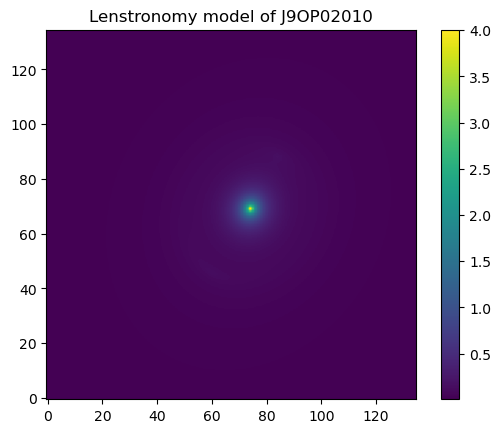

In [11]:
side = 5  # arcseconds
num_pix = 45 * oversample_factor
delta_pix = side / num_pix  # size of pixel in angular coordinates

ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

image = imageModel.image(kwargs_lens=kwargs_lens,
                        kwargs_source=kwargs_source_light_amp,
                        kwargs_lens_light=kwargs_lens_light_amp)

# TODO correct for spreading counts across more pixels
image = image / (oversample_factor ** 2)

plt.imshow(image)
plt.title('Lenstronomy model of '+ data_set_name)
# plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
plt.colorbar()
plt.show()

model_array_path = os.path.join(repo_path, 'arrays', 'SLACS', dataset.get('target_name') + '_model_' + str(oversample_factor) + '.npy')
# np.save(model_array_path, image)

HST's pixel scale: 0.08


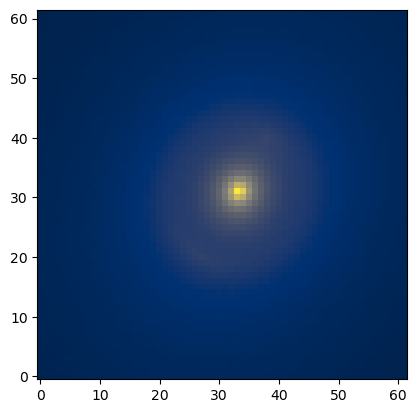

In [12]:
HST_wfc3_f160w = HST(band='WFC3_F160W', psf_type='GAUSSIAN', coadd_years=None)

kwargs_wfc3_f160w = HST_wfc3_f160w.kwargs_single_band()

hst_pixel_scale = HST_wfc3_f160w.kwargs_single_band().get('pixel_scale')
print('HST\'s pixel scale: ' + str(hst_pixel_scale))

hst_num_pix = int(5 / hst_pixel_scale)

sim_wfc3_f160w = SimAPI(numpix=hst_num_pix, kwargs_single_band=kwargs_wfc3_f160w, kwargs_model=kwargs_model)

imSim_kwargs_wfc3_f160w = sim_wfc3_f160w.image_model_class(kwargs_numerics)

image_wfc3_f160w = imSim_kwargs_wfc3_f160w.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light_amp, kwargs_source=kwargs_source_light_amp)

# add noise
image_wfc3_f160w += sim_wfc3_f160w.noise_for_model(model=image_wfc3_f160w)

hst_image = np.zeros((image_wfc3_f160w.shape[0], image_wfc3_f160w.shape[1], 1), dtype=float)
hst_image[:,:,0] = plot_util.sqrt(image_wfc3_f160w, scale_min=0, scale_max=10000)

plt.imshow(hst_image, aspect='equal', cmap='cividis')
plt.show()